**${\mathcal P}^1$ comme machine**. 
On rappelle l'idée de la construction:
* $\psi_i(t):=\max(t-t_i,0)$ donne des fonctions de ${\mathcal P}^1_h$ qui s'annullent pour $t\le t_i$. Sa dérivée a une discontinuité en $t_i$.
* $\phi_i$, fonction de base canonique de ${\mathcal P}^1_h$, dont la dérivée possède trois points de disconuité $t_{i-1}, t_i, t_{i+1}$ s'écrit donc comme $$\phi_i = \alpha_i \psi_{i-1} + \beta_i \psi_i + \gamma_i \psi_{i+1}.$$
* on trouve les coefficients $\alpha,\beta,\gamma$ par les trois conditions $$\phi(t_{i-1})=0, \quad\phi(t_{i})=1, \quad\phi(t_{i+1})=0. $$
*Remarque* : on ajoute deux points au maillage pour les fonctions de bases aux extrémités.
*Remarque* : on les appele ici ${\mathcal S}^1$, car c'est aussi l'espace de spline d'ordre un. Le  ${\mathcal S}^k$, spline d'ordre $k$ de class $C^{k-1}$ s'écrivent d'ailleurs de façon similaire.

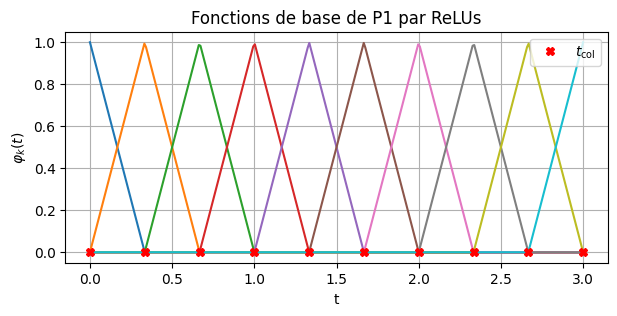

In [16]:
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
import numpy as np


def relu_hat_basis(t, t_machine):
    t_machine = jnp.sort(t_machine)
    n_machine = len(t_machine)

    # Ghost points
    t_left = t_machine[0] - (t_machine[1]-t_machine[0])
    t_right = t_machine[-1] + (t_machine[-1]-t_machine[-2])
    t_full = jnp.concatenate([jnp.array([t_left]), t_machine, jnp.array([t_right])])

    dt = t_full[1:] - t_full[:-1]
    dtinv = 1.0 / dt

    # Make alpha, beta, gamma exactly length n_machine
    alpha = dtinv[1:1+n_machine]   # slice of length 10
    gamma = dtinv[0:n_machine]     # slice of length 10
    beta = -alpha - gamma

    W = jnp.ones(len(t_full))
    b = -t_full

    y = jnp.maximum(0.0, W[:, None] * t[None,:] + b[:, None])

    # Now all slices have length n_machine
    phi = alpha[:, None] * y[2:2+n_machine,:] \
        + beta[:, None] * y[1:1+n_machine,:] \
        + gamma[:, None] * y[0:0+n_machine,:]

    return phi   # shape (n_machine, len(t))    

# Points de collocation
t0, t1, n_colloc = 0.0, 3.0, 10
t_colloc = jnp.linspace(t0, t1, n_colloc)
t_plot = jnp.linspace(t0, t1, 300)
phi = np.asarray(relu_hat_basis(t_plot, t_colloc))

plt.figure(figsize=(7,3))
plt.plot(t_plot, phi.T)
plt.plot(np.asarray(t_colloc), np.zeros_like(np.asarray(t_colloc)), 'Xr', label=r'$t_{\rm col}$')
plt.title("Fonctions de base de P1 par ReLUs")
plt.xlabel("t")
plt.ylabel(r"$\varphi_k(t)$")
plt.grid(True)
plt.legend()
plt.show()

Maintant, on utilise notre classe S1 pour interpoler une fonction. Notre 'machine' est un réseau de neurones consistant en une dernière couche linéaire, les coefficients $c\in\mathbb R^{n+1}$ dans
$$u_h(t) = \sum_{i=0}^n c_i \phi_i(t).$$
On minimise la perte
$${\mathcal L}(c) = \frac{1}{2n}\sum_{i=0}^n \left(u(t_i)-u_h(t_i)\right)^2.$$
Il s'agit ici de voir comment fonctionne notre 'apprentissage'. On pourrait trouver la solution plus simplement...

Epoch       0, Loss: 4.500e-01
Epoch      10, Loss: 1.160e-02
Epoch      20, Loss: 2.710e-04
Epoch      30, Loss: 8.017e-06
Epoch      40, Loss: 3.001e-07
Epoch      50, Loss: 1.799e-08
Epoch      60, Loss: 4.183e-10
Epoch      70, Loss: 7.420e-12
Epoch      80, Loss: 2.132e-13
Epoch      90, Loss: 8.527e-15


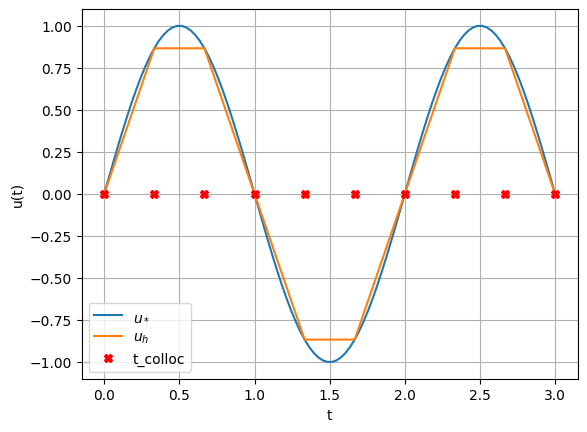

In [18]:
import optax

t0, t1, n_colloc = 0, 3, 10
t_colloc = np.linspace(t0, t1, n_colloc)

def u(t):
    return np.sin(np.pi * t)

data = (t_colloc, u(t_colloc))

def machine(t_machine, coeff, t):
    phi = relu_hat_basis(t_machine, t)  # (n_colloc, len(t))
    return jnp.dot(coeff, phi)

def loss(params):
    res = data[1] - machine(t_colloc, params, data[0])
    return jnp.mean(res ** 2)
 
params = jnp.zeros(shape=(len(t_colloc)))
optimizer = optax.lbfgs(learning_rate=0.1)
opt_state = optimizer.init(params)
@jax.jit
def train_step(params, opt_state):
    loss_value, grads = jax.value_and_grad(loss)(params)
    updates, opt_state = optimizer.update(
        grads, opt_state, params, value=loss_value, grad=grads, value_fn=loss
    )
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss_value, grads, updates

n_epochs = 100
for epoch in range(n_epochs):
    params, opt_state, loss_value, grads, updates = train_step(params, opt_state)
    if epoch % 10== 0:
        print(f"Epoch {epoch:7d}, Loss: {loss_value:.3e}")

t_plot = np.linspace(t0, t1, 100)
plt.plot(t_plot, u(t_plot), label=r'$u_*$')
plt.plot(t_plot, np.array(s1.forward(params, t_plot)), label=r'$u_h$')
plt.plot(t_colloc, np.zeros_like(t_colloc), 'Xr', label='t_colloc')
plt.legend()
plt.xlabel("t")
plt.ylabel("u(t)")
plt.grid(True)
plt.show()


Même chose, mais avec des points de la machine différents de la collocation. Notre problème devient un véritable problème de moindres carrés. *D'ailleurs, peut-on calcluer la solutin à la main ? Que peut-on dire de l'erreur ? Est-il plus petite ou plus grande qu'avant ?*

On rencontre un problème typique de l'apprentissage : la valeur de la perte est difficile à interpréter. Ne pouvant pas s'attenre à ce qu'elle converge vers zéro, quand devrait-on s'arrêter ?

Epoch       0, Loss: 4.833e-01
Epoch      10, Loss: 2.822e-02
Epoch      20, Loss: 2.734e-03
Epoch      30, Loss: 1.088e-03
Epoch      40, Loss: 9.813e-04
Epoch      50, Loss: 9.744e-04
Epoch      60, Loss: 9.740e-04
Epoch      70, Loss: 9.740e-04
Epoch      80, Loss: 9.739e-04
Epoch      90, Loss: 9.739e-04


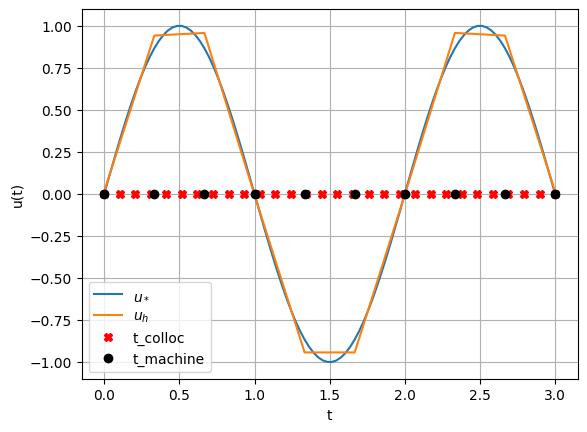

In [9]:
import optax

t0, t1, n_colloc, n_machine = 0, 3, 30, 10
t_colloc = np.linspace(t0, t1, n_colloc)
t_machine= np.linspace(t0, t1, n_machine)
s1 = S1(t_machine)

def u(t):
    return np.sin(np.pi * t)

data = (t_colloc, u(t_colloc))

def loss(params):
    res = data[1] - s1.forward(params,data[0])
    return jnp.mean(res ** 2)
 
params = jnp.zeros(shape=(s1.alpha.shape[0]))

optimizer = optax.lbfgs(learning_rate=0.001)
opt_state = optimizer.init(params)
@jax.jit
def train_step(params, opt_state):
    loss_value, grads = jax.value_and_grad(loss)(params)
    updates, opt_state = optimizer.update(
        grads, opt_state, params, value=loss_value, grad=grads, value_fn=loss
    )
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss_value, grads, updates

n_epochs = 100
for epoch in range(n_epochs):
    params, opt_state, loss_value, grads, updates = train_step(params, opt_state)
    if epoch % 10== 0:
        print(f"Epoch {epoch:7d}, Loss: {loss_value:.3e}")

t_plot = np.linspace(t0, t1, 100)
plt.plot(t_plot, u(t_plot), label=r'$u_*$')
plt.plot(t_plot, np.array(s1.forward(params, t_plot)), label=r'$u_h$')
plt.plot(t_colloc, np.zeros_like(t_colloc), 'Xr', label='t_colloc')
plt.plot(t_machine, np.zeros_like(t_machine), 'ok', label='t_machine')
plt.legend()
plt.xlabel("t")
plt.ylabel("u(t)")
plt.grid(True)
plt.show()


Maintenant on essaie avec un vrai réseau de neurones : la première couche génère les fonctions de bases sur un maillage, dont les points sont aussi des paramètres. *Il s'agit d'uné méthode adaptative.*

Comme nous avons plusieurs paramètres, on utilise un dictionnaire. La base n'est plus une classe, juste une fonction.

* On peut être surpris du bon fonctionnement. Cela dépend largement de l'initialisation.
* Est-ce que l'erreur est plus petite qu'avant ? Qu'est-ce qu'on peut dire ?

Epoch       0, Loss: 4.833e-01
Epoch      10, Loss: 3.146e-02
Epoch      20, Loss: 4.712e-03
Epoch      30, Loss: 2.977e-03
Epoch      40, Loss: 1.929e-03
Epoch      50, Loss: 1.283e-03
Epoch      60, Loss: 1.213e-03
Epoch      70, Loss: 1.208e-03
Epoch      80, Loss: 1.208e-03
Epoch      90, Loss: 1.208e-03


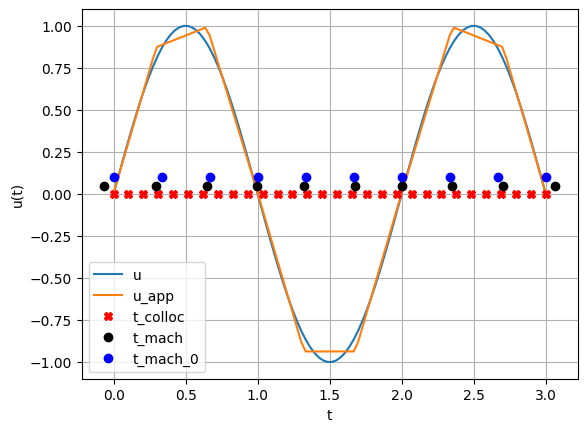

In [12]:
import optax

t0, t1, n_colloc, n_machine = 0, 3, 30, 10
t_colloc = np.linspace(t0, t1, n_colloc)

def u(t):
    return np.sin(np.pi * t)

def relu_hat_basis(t, t_machine):
    t_machine = jnp.sort(t_machine)
    n_machine = len(t_machine)

    # Ghost points
    t_left = t_machine[0] - (t_machine[1]-t_machine[0])
    t_right = t_machine[-1] + (t_machine[-1]-t_machine[-2])
    t_full = jnp.concatenate([jnp.array([t_left]), t_machine, jnp.array([t_right])])

    dt = t_full[1:] - t_full[:-1]
    dtinv = 1.0 / dt

    # Make alpha, beta, gamma exactly length n_machine
    alpha = dtinv[1:1+n_machine]   # slice of length 10
    gamma = dtinv[0:n_machine]     # slice of length 10
    beta = -alpha - gamma

    W = jnp.ones(len(t_full))
    b = -t_full

    y = jnp.maximum(0.0, W[:, None] * t[None,:] + b[:, None])

    # Now all slices have length n_machine
    phi = alpha[:, None] * y[2:2+n_machine,:] \
        + beta[:, None] * y[1:1+n_machine,:] \
        + gamma[:, None] * y[0:0+n_machine,:]

    return phi   # shape (n_machine, len(t))    

def model(params, t):
    phi = relu_hat_basis(t, params["t_machine"])   # (n_machine, n_points)
    return jnp.dot(params["weights"], phi)

def loss(params):
    res = model(params, t_colloc) - u(t_colloc)
    return jnp.mean(res**2)

params = {
    "weights": jnp.zeros(n_machine),
    "t_machine": jnp.linspace(0, 3, n_machine)     # trainable mesh!
}
t_machine_0 = params["t_machine"]


optimizer = optax.lbfgs(learning_rate=0.001)
opt_state = optimizer.init(params)
@jax.jit
def train_step(params, opt_state):
    loss_value, grads = jax.value_and_grad(loss)(params)
    updates, opt_state = optimizer.update(
        grads, opt_state, params, value=loss_value, grad=grads, value_fn=loss
    )
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss_value, grads, updates

n_epochs = 100
for epoch in range(n_epochs):
    params, opt_state, loss_value, grads, updates = train_step(params, opt_state)
    if epoch % 10== 0:
        print(f"Epoch {epoch:7d}, Loss: {loss_value:.3e}")


t_machine = params["t_machine"]
t_plot = np.linspace(t0, t1, 100)
plt.plot(t_plot, u(t_plot), label='u')
plt.plot(t_plot, np.array(model(params, t_plot)), label='u_app')
plt.plot(t_colloc, np.zeros_like(t_colloc), 'Xr', label='t_colloc')
plt.plot(t_machine , np.zeros_like(t_machine)+0.05, 'ok', label='t_mach')
plt.plot(t_machine_0 , np.zeros_like(t_machine_0)+0.1, 'ob', label='t_mach_0')
plt.legend()
plt.xlabel("t")
plt.ylabel("u(t)")
plt.grid(True)
plt.show()
